In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

## Get Khurana enhancers with Khurana scores, and associated Chen scores 

In [2]:
import pandas as pd

def read_khurana_enhancers_intersect_chen_windows():
  # bed file created using: 
  # experiments/germline-model/chen-et-al-2022/intersect-khurana-enhancers-with-chen-windows.sh
  df = pd.read_csv(
      f"{CONSTRAINT_TOOLS_DATA}/khurana/khurana-enhancers-intersect-chen-windows.bed", 
      sep = '\t',
      names = [
          'chrom_enhancer', 'start_enhancer', 'end_enhancer', 
          'enhancer_deletion_status', 'enhancer_predicted_LoF_tolerance_status', 'enhancer_predicted_LoF_tolerance_prob', 
          'chrom_window', 'start_window', 'end_window', 
          'new_chen_score_window'
      ]
  )
  df['negative_new_chen_score_window'] = -df['new_chen_score_window']
  df = df.drop(columns=[
    'new_chen_score_window',
    'chrom_window', 'start_window', 'end_window'
  ])
  return df 

khurana_enhancers_intersect_chen_windows = read_khurana_enhancers_intersect_chen_windows()
khurana_enhancers_intersect_chen_windows

,chrom_enhancer,start_enhancer,end_enhancer,enhancer_deletion_status,enhancer_predicted_LoF_tolerance_status,enhancer_predicted_LoF_tolerance_prob,negative_new_chen_score_window
0,chr1,794220,794420,NotDeleted,LoF-tolerant,0.863272,-4.034545
1,chr1,794620,795020,NotDeleted,LoF-tolerant,0.919113,-4.034545
2,chr1,794620,795020,NotDeleted,LoF-tolerant,0.919113,-4.072486
3,chr1,803820,804220,NotDeleted,LoF-tolerant,0.884506,-3.779493
4,chr1,803820,804220,NotDeleted,LoF-tolerant,0.884506,-0.767485
...,...,...,...,...,...,...,...
351771,chr22,50739172,50740572,NotDeleted,Low-LoF-tolerance,0.263704,-2.476451
351772,chr22,50748972,50749972,NotDeleted,LoF-tolerant,0.737725,-2.543021
351773,chr22,50754572,50754772,NotDeleted,Low-LoF-tolerance,0.386335,0.087238
351774,chr22,50772572,50772972,NotDeleted,LoF-tolerant,0.902392,-2.204285


In [3]:
def aggregate_over_windows(df): 
    groups = df.groupby([
        'chrom_enhancer', 'start_enhancer', 'end_enhancer', 
        'enhancer_deletion_status', 'enhancer_predicted_LoF_tolerance_status', 'enhancer_predicted_LoF_tolerance_prob',         
    ])
    aggregation_functions = {'negative_new_chen_score_window': ['min', 'count']}
    aggregated = groups.agg(aggregation_functions)
    
    df = aggregated.reset_index()
    df.columns = [' '.join(col[::-1]).strip() for col in df.columns.values]
    return df

enhancers_with_khurana_and_chen_scores = aggregate_over_windows(khurana_enhancers_intersect_chen_windows)
enhancers_with_khurana_and_chen_scores

,chrom_enhancer,start_enhancer,end_enhancer,enhancer_deletion_status,enhancer_predicted_LoF_tolerance_status,enhancer_predicted_LoF_tolerance_prob,min negative_new_chen_score_window,count negative_new_chen_score_window
0,chr1,794220,794420,NotDeleted,LoF-tolerant,0.863272,-4.034545,1
1,chr1,794620,795020,NotDeleted,LoF-tolerant,0.919113,-4.072486,2
2,chr1,803820,804220,NotDeleted,LoF-tolerant,0.884506,-3.779493,2
3,chr1,804820,805620,NotDeleted,LoF-tolerant,0.824233,-3.761746,2
4,chr1,828420,830620,NotDeleted,Low-LoF-tolerance,0.348280,-2.366455,2
...,...,...,...,...,...,...,...,...
201406,chr9,138037348,138037548,NotDeleted,LoF-tolerant,0.869391,-1.328952,1
201407,chr9,138037948,138038948,NotDeleted,LoF-tolerant,0.957399,-2.355119,2
201408,chr9,138040548,138041148,NotDeleted,LoF-tolerant,0.962550,-2.570888,2
201409,chr9,138052748,138054748,NotDeleted,LoF-tolerant,0.591343,-5.088021,2


In [5]:
def predicted_status_determined_by_predicted_probability(df):    
    max_prob = max(df[df['enhancer_predicted_LoF_tolerance_status'] == 'Low-LoF-tolerance']['enhancer_predicted_LoF_tolerance_prob'])
    print(f'max prob of Low-LoF-tolerance enhancers: {max_prob}')

    min_prob = min(df[df['enhancer_predicted_LoF_tolerance_status'] == 'LoF-tolerant']['enhancer_predicted_LoF_tolerance_prob'])
    print(f'min prob of LoF-tolerant enhancers: {min_prob}')

predicted_status_determined_by_predicted_probability(enhancers_with_khurana_and_chen_scores)

max prob of Low-LoF-tolerance enhancers: 0.499996693121693
min prob of LoF-tolerant enhancers: 0.500015271765271


## Khurana scores are weakly correlated with Chen scores 

<AxesSubplot:xlabel='enhancer_predicted_LoF_tolerance_prob', ylabel='min negative_new_chen_score_window'>

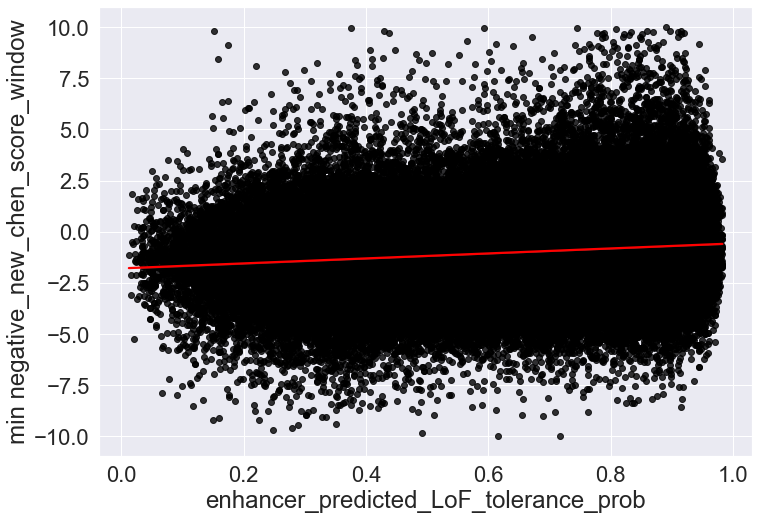

In [6]:
import seaborn as sns

# set size of figure using seaborn 
sns.set(rc={'figure.figsize':(11.7,8.27)})

# set background color of figure using seaborn
sns.set(style="whitegrid", color_codes=True)

# set font size of axis labels two-foled using seaborn
sns.set(font_scale=2)

# scatter plot with regression line
sns.regplot(
    x=enhancers_with_khurana_and_chen_scores['enhancer_predicted_LoF_tolerance_prob'],
    y=enhancers_with_khurana_and_chen_scores['min negative_new_chen_score_window'],
    scatter_kws={"color": "black"},
    line_kws={"color": "red"},
)

## True negatives  

In [7]:
# all enhancers from previous section are "not homozygously deleted" in 1000 Genomes Project: 
enhancers_with_khurana_and_chen_scores['enhancer_deletion_status'].value_counts()

NotDeleted    201411
Name: enhancer_deletion_status, dtype: int64

In [8]:
# therefore we need a set of enhancers that are homozygously deleted in 1000 Genomes Project
# we'll call them "true negatives"

In [10]:
# get enhancers that are homozygously deleted in 1000 Genomes Project

def read_true_negatives():
  # lof-tolerant-enhancers.hg19.sorted.bed created using: 
  # download-process-data/khurana/convert-to-bed.ipynb
  # lof-tolerant-enhancers.hg38.hg19.sorted.bed created using: 
  # https://genome.ucsc.edu/cgi-bin/hgLiftOver

  df = pd.read_csv(
      f"{CONSTRAINT_TOOLS_DATA}/khurana/lof-tolerant-enhancers.hg38.hg19.sorted.bed", 
      sep = '\t',
      header = None,
  )
  df = df.drop(columns=[3, 4])
  df.columns = ['chrom_enhancer', 'start_enhancer', 'end_enhancer']
  return df 

true_negatives = read_true_negatives()
true_negatives

,chrom_enhancer,start_enhancer,end_enhancer
0,chr1,831220,832820
1,chr1,1508220,1509820
2,chr1,8124140,8124940
3,chr1,8129540,8129940
4,chr1,9535741,9535941
...,...,...,...
881,chrX,147767082,147768082
882,chrX,151417528,151417728
883,chrX,151708928,151709128
884,chrX,151709528,151709728


In [11]:
# check that none of the true negatives coincide with enhancers from previous section 
enhancers_with_khurana_and_chen_scores.merge(
    true_negatives,
    on=['chrom_enhancer', 'start_enhancer', 'end_enhancer'],
    how='inner'
)

,chrom_enhancer,start_enhancer,end_enhancer,enhancer_deletion_status,enhancer_predicted_LoF_tolerance_status,enhancer_predicted_LoF_tolerance_prob,min negative_new_chen_score_window,count negative_new_chen_score_window


In [12]:
# second check that none of the true negatives coincide with enhancers from previous section 

import subprocess

# run shell command and return output as a string
def shell(cmd):
    return subprocess.run(
        cmd,
        shell=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    ).stdout.decode("utf-8").strip()

shell(
  (
    f"bedtools intersect -wa -wb"
    f"-a {CONSTRAINT_TOOLS_DATA}/khurana/lof-tolerant-enhancers.hg38.hg19.sorted.bed"
    f"-b {CONSTRAINT_TOOLS_DATA}/khurana/enhancers-and-khurana-scores.hg38.sorted.bed"      
    f" | wc -l"
  )
)

'0'

## True Positives

In [14]:
def read_true_positives():
  # low-lof-tolerance-enhancers.hg19.bed created using: 
  # download-process-data/khurana/convert-to-bed.ipynb
  # low-lof-tolerance-enhancers.hg38.hg19.sorted.bed created using: 
  # https://genome.ucsc.edu/cgi-bin/hgLiftOver

  df = pd.read_csv(
      f"{CONSTRAINT_TOOLS_DATA}/khurana/low-lof-tolerance-enhancers.hg38.hg19.sorted.bed", 
      sep = '\t',
      header = None,
  )
  df = df.drop(columns=[3, 4])
  df.columns = ['chrom_enhancer', 'start_enhancer', 'end_enhancer']
  return df 

true_positives = read_true_positives()
true_positives

,chrom_enhancer,start_enhancer,end_enhancer
0,chr1,61587728,61589928
1,chr1,87355917,87357117
2,chr1,87355917,87357117
3,chr1,169941659,169943659
4,chr2,66069666,66071266
5,chr2,163805290,163805490
6,chr2,172071872,172073872
7,chr2,176075472,176076072
8,chr3,9427916,9430116
9,chr3,147311813,147313613


In [17]:
# check that none of the true positives coincide with enhancers from first section 
enhancers_with_khurana_and_chen_scores.merge(
    true_positives,
    on=['chrom_enhancer', 'start_enhancer', 'end_enhancer'],
    how='inner'
)

,chrom_enhancer,start_enhancer,end_enhancer,enhancer_deletion_status,enhancer_predicted_LoF_tolerance_status,enhancer_predicted_LoF_tolerance_prob,min negative_new_chen_score_window,count negative_new_chen_score_window


In [18]:
# second check that none of the true positives coincide with enhancers from first section 

shell(
  (
    f"bedtools intersect -wa -wb"
    f"-a {CONSTRAINT_TOOLS_DATA}/khurana/low-lof-tolerance-enhancers.hg38.hg19.sorted.bed"
    f"-b {CONSTRAINT_TOOLS_DATA}/khurana/enhancers-and-khurana-scores.hg38.sorted.bed"      
    f" | wc -l"
  )
)

'0'

## [TODO] Assess performance of Khurana model and Chen models using true negatives and true positives

In [ ]:
# TODO [once Khurana reports scores for control enhancers]

# Look at the CDF of scores (Chen, Khurana) for all enhancers, 
# just those annotated as "vista", 
# and just those annotated as "LoF-tolerant", similar to Fig 4A